# Pubmed Parser
### Textual Analysis

__Notebook Description:__ PubmedParser is a Python-based web scraper specifically designed to scrape, parse, and analyze NCBI's online pubmed database (https://www.ncbi.nlm.nih.gov/pubmed). This scraper can be used in a number of ways, one of which is utilized here to performa a textual analysis of specific researchers' abstracts. <br>
__Notebook Owner:__ Rahim Hashim <br>
__Contact:__ rh2898@columbia.edu <br>
__\*Dependencies:__ In order to reproduce the environment used in the notebook, activate your virtual environment with the *environment.yml* file contained in the directory (see: [Managing Virtual Environments](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) for more details): *conda env create -f environment.yml*

***

### Import Libraries
__Public List:__ os, re, sys, string, datetime, pandas, numpy, tqdm, ntlk, collections, urllib, bs4, unidecode, matplotlib<br>
__Additional Code:__ Regions

After following the directions for Managing Virtual Environments above, all of the libraries from the public list will be set up. Regions.py included in the directory will provide the rest of the functions used in this codebase. 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import string
import datetime
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
# For download info / documentation on Natural Language Toolkit (nltk):
#    https://www.nltk.org/
import nltk
nltk.download('punkt') # only needs to be downloaded once
nltk.download('stopwords') # only needs to be downloaded once
from collections import defaultdict

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahimhashim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahimhashim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***

### Assigning Search Term Parameters

First we will assign the search parameters for scraping. In particular, test the key terms you will be searcing for in the database of choice, and then assign it to the SearchParameters.searchTerms attribute. 

In [2]:
from searchObjects import SearchParameters

parameters = {}
# Database : Specified NCBI database
#   Options = Pubmed [pubmed] | Pubmed Central [PMC] | Unigene [Unigene] | Others [Look Up Key]
parameters['database'] = 'pubmed'
# SearchTerms : PubMed desired search term(s)
parameters['searchTerms'] = ['Salzman CD', 'Fusi S']
# searchLimit : Number of articles that the program will search through for each search term
parameters['searchLimit'] = 100
# startIndex : Index of which article to start search on (e.g. IdIndex = 10 does not include 9 most recent articles published from SearchTerms)
parameters['startIndex'] = 0
# abstractFlag : Flag to hide (0) or capture (1) abstract info in last column
parameters['abstractFlag'] = 1
# emailFilter : Filter for contact-capturing - (0) for all results, (1) for articles with author emails only 
parameters['emailFilter'] = 0
# geographyFilter : Filter to show results only from specified [country1, country2...] or keep all countries ([])
# i.e. --> geographyFilter = ['US', 'USA', 'United States', 'United States of America']
parameters['geographyFilter'] = []
#authorTermSearch : When search term is author name, (1) results match last name of search terms only or (2) all authors 
parameters['authorTermSearch'] = 2
# authorScore = Flag to keep off (0) or turn on (1) author score column
parameters['authorScoreFlag'] = 0

searchParameters = SearchParameters(parameters)

***
### Generating List of Database Search Result URLs

Using the [NCBI Entrez API](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch), eSearchLinkGenerator generates an XML containing the list of URLs for the articles returned by searchParameters.searchTerms attribute, up until the amount of articles specified by searchLimit. resultsList generates a nested list of all article URLs.

In [3]:
from entrezParser import eSearchLinkGenerator, PMID_ListGenerator

def entrezSearch():
    '''
    entrezSearch generates resultsList, which is
    a list of all article URLs for each search term.
    '''
    eSearchCore = 'http://eutils.ncbi.nlm.nih.gov/entrez//eutils/esearch.fcgi/?db=&term=&retmax=&retstart='
    eSearchLinkList = eSearchLinkGenerator(eSearchCore, searchParameters)
    resultsList = PMID_ListGenerator(eSearchLinkList)
    return(resultsList)

resultsList = entrezSearch()

Generating Entrez XML...
   [Salzman CD] complete
   [Fusi S] complete

Generating list of PMIDs...
  Salzman CD[Author]: 35 results
  Fusi S[Author]: 100 results


***
### Parsing Data

For each searchTerm provided to searchParameters, dataParser will take each of the article URLs and parse the specified information, inserting it into a multi-nested dictionary queriesHash to be further analyzed.

In [4]:
from linksParser import linksParser

def dataParser(resultsList):
    '''
    dataParser creates a multi-nested dictionary
      queriesHash
        | 
        queriesHash[query]
          |
          queriesHash[query][PMID]
            |
            articleTitle
            journalTitle
            dataPublished
            ...
    '''
    print('\nParsing info for search terms...')
    queriesHash = defaultdict(lambda: defaultdict(list)) # primary key = pubmed query
    searchesHash = defaultdict(lambda: defaultdict(list)) # primary key = PMID
    for a_index, termLinks in enumerate(resultsList):
        query = searchParameters.searchTerms[a_index]
        searchesHash = linksParser(a_index, termLinks, searchParameters,
                                   query, searchesHash)
        queriesHash[query] = searchesHash
    return queriesHash

searchesHash = dataParser(resultsList)

  0%|          | 0/35 [00:00<?, ?it/s]


Parsing info for search terms...
  Salzman CD


  0%|          | 0/100 [00:00<?, ?it/s]

  Fusi S


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


### Year-by-Year Analysis

The first analysis we'll be performing is year-by-year lexicon frequency. In the example queries provided above, we introduced two authors (Salzman CD, Fusi S) and captured all meta-info (title, journal, date published, etc), and importantly all of the abstracts for each of the author's articles. 

In pre-processing we'll __separate stop words__, defined by [NLTK](https://www.nltk.org/book/ch02.html) as: "high-frequency words like the, to and also that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts." The data will still be preserved in yearsHash\[year\]\['wordsLeft'\] if you're interested in analyzing something like self- vs. other-referential pronoun usage  

2019


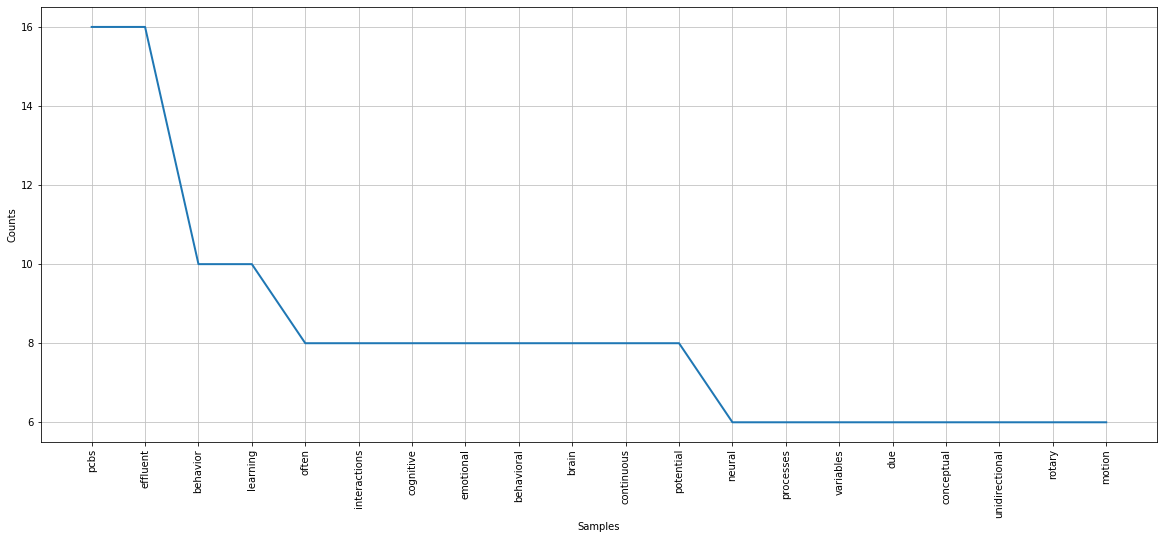

2018


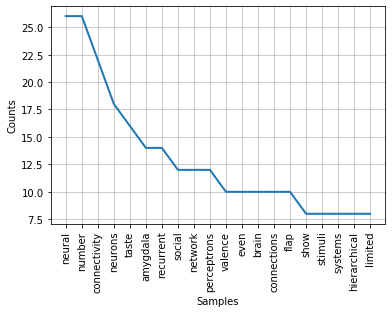

2017


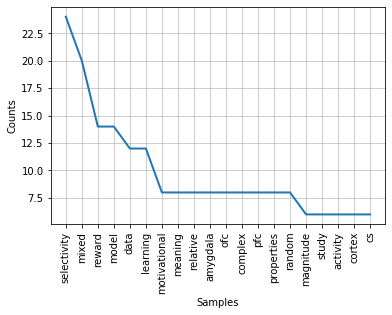

2015


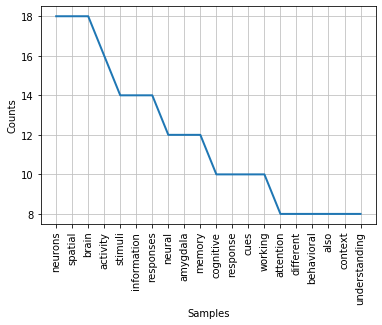

2014


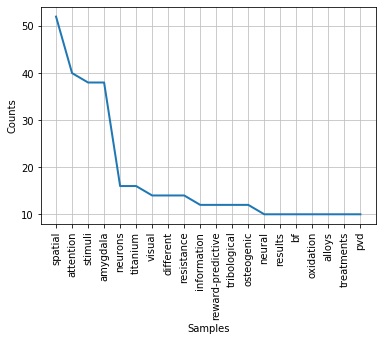

2013


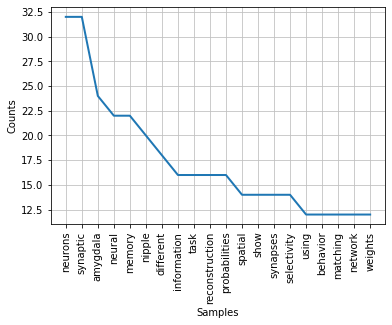

2012


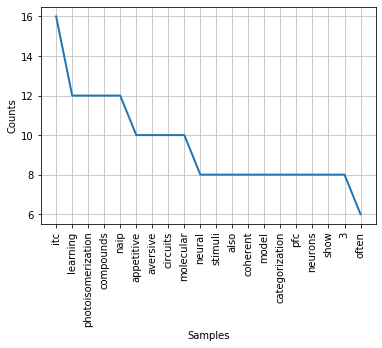

2011


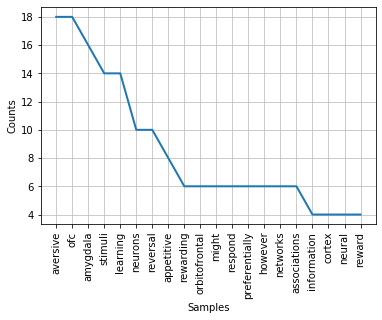

2010


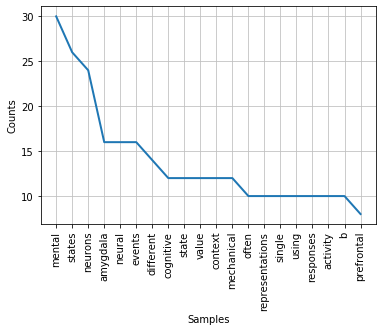

2009


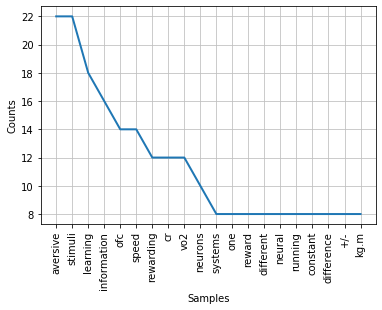

2008


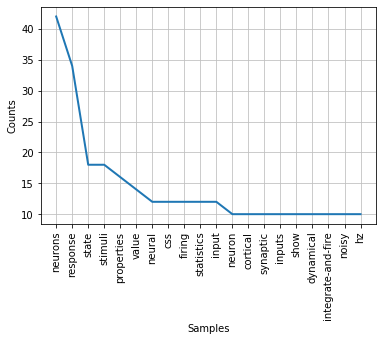

2007


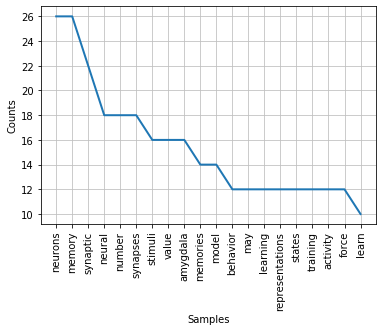

2006


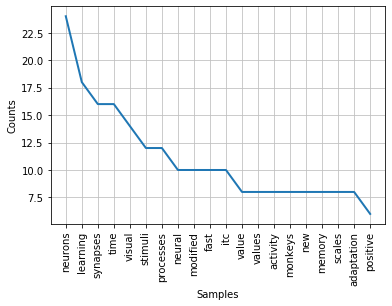

2005


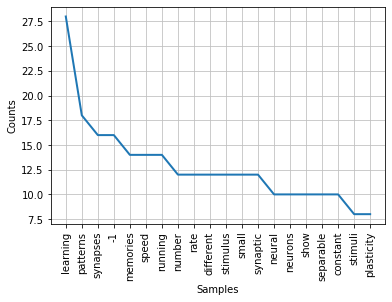

1994


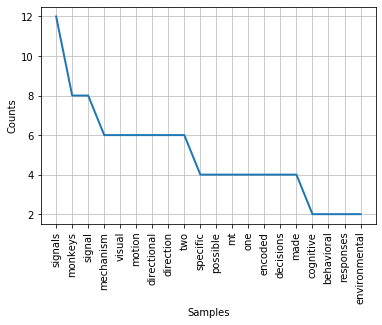

1993


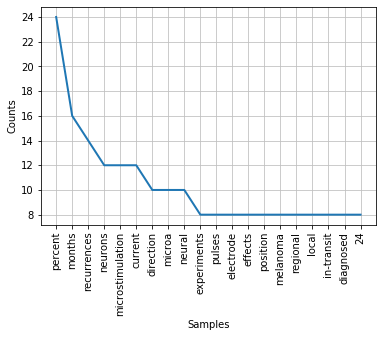

1992


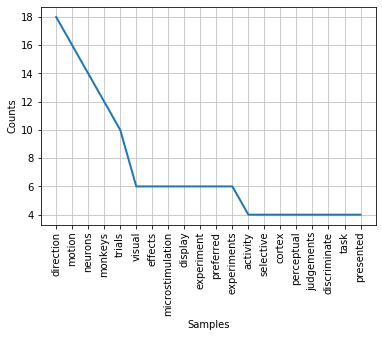

1990


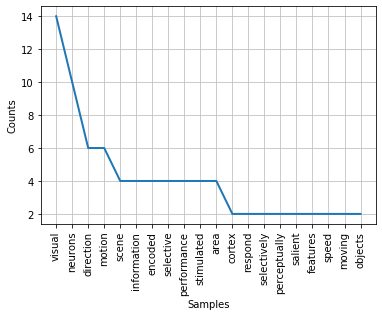

2020


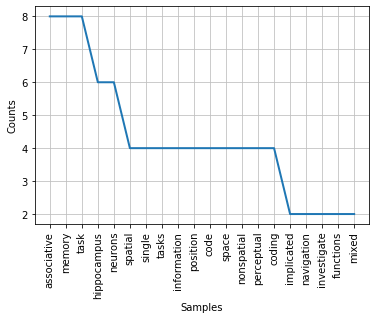

2016


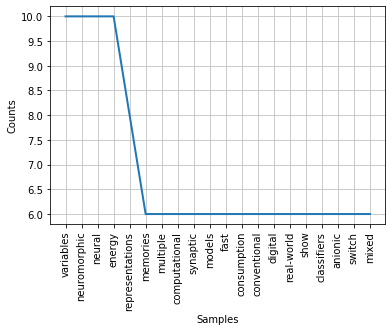

2003


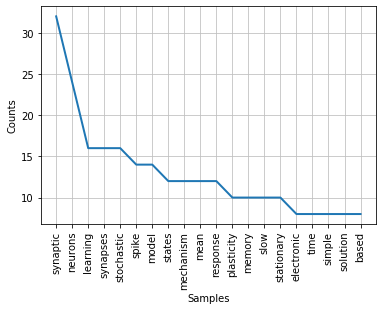

2004


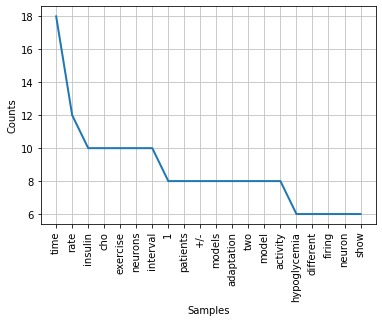

2002


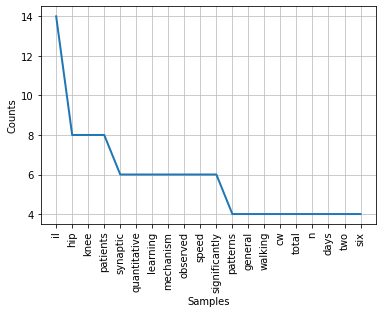

2001


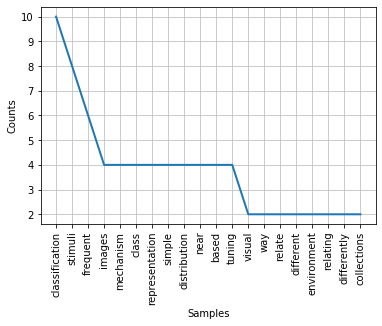

2000


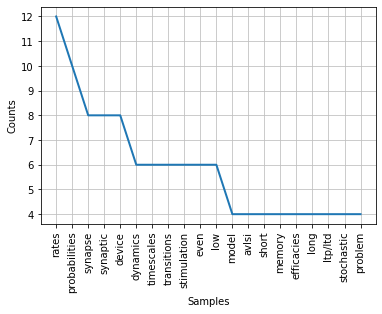

1998


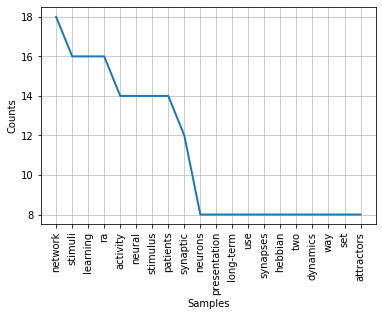

1999


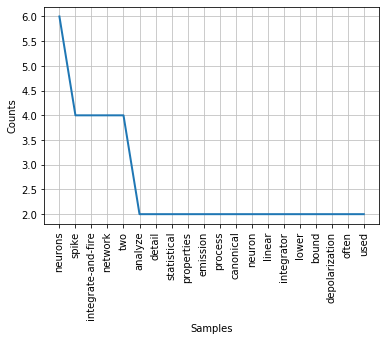

1997


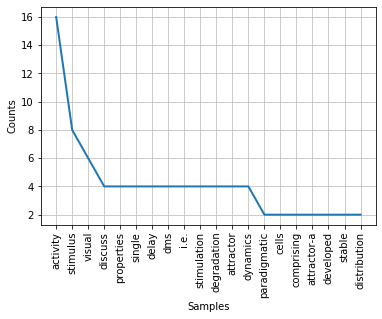

1995


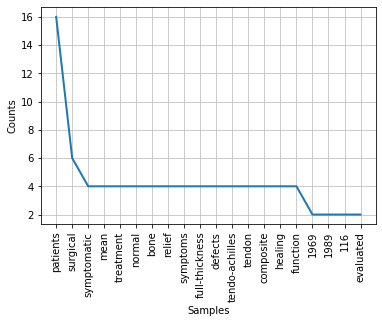

1991


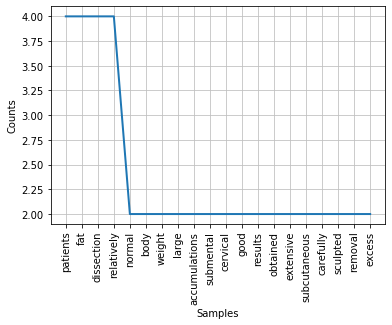

1987


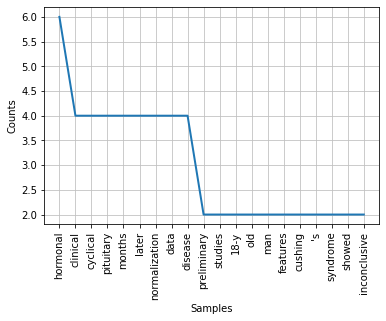

1985


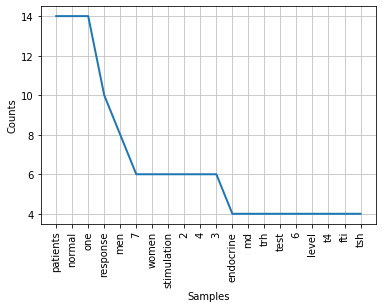

1984


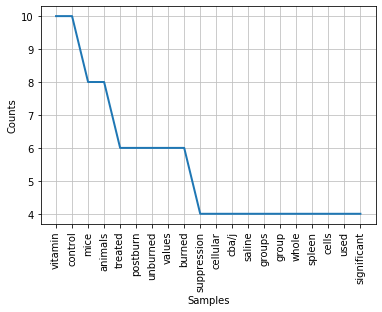

1983


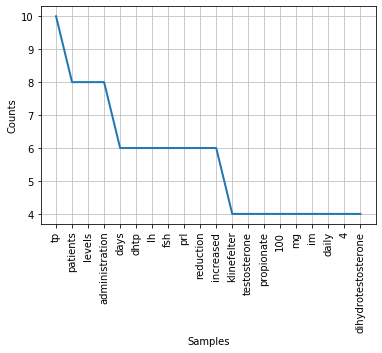

In [14]:
from collections import Counter
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

def wordCounter(year, yearHash):
    counts = Counter(yearHash['wordsKept'])
    words = counts.keys()
    word_counts = counts.values()
    word_counts, words = (list(t) for t in zip(*sorted(zip(word_counts, words))))
    total_words = sum(word_counts)
    word_freq = [x / total_words for x in word_counts]
    words = words[::-1]
    word_freq = word_freq[::-1]
    print(year)
    fdist = FreqDist(yearHash['wordsKept'])
    fdist.plot(20)

def yearExaminer(searchesHash):
    '''
    yearExaminer buckets the results for each searchTerm 
    by year of publication and analyzes the lexicon used
    in the abstracts.
    
    pre-processing: 
       1) lower-case for all words
       2) tokenize to split words from punctuation
       3) separates all punctuation to yearsHash[year]['punctuation'] (for sentence volume comparison)
       4) separates all stop words to yearsHash[year]['wordsLeft']
    '''
    
    stopWords = nltk.corpus.stopwords.words('english')
    punctuation = string.punctuation
    yearsHash = defaultdict(lambda: defaultdict(list))
    for query in searchesHash.keys():
        for date in searchesHash[query].keys():
            year = searchesHash[query][date]['datePublished'][:4]
            # word_tokenize splits off punctuation other than periods
            abstract = nltk.tokenize.word_tokenize(searchesHash[query][date]['abstract'].lower())
            for word in abstract:
                if word in punctuation:
                    yearsHash[year]['punctuation'].append(word)
                elif word not in stopWords:
                    yearsHash[year]['wordsKept'].append(word)
                else:
                    yearsHash[year]['wordsLeft'].append(word)
            yearsHash[year]['query'] = query
    plt.figure(figsize=(20, 8))
    for year in yearsHash.keys():
        wordCounter(year, yearsHash[year])
    return(yearsHash)
            
yearsHash = yearExaminer(searchesHash)